# DELE CA2 (GAN)


### Problem: Singapore Pictures in Van-Gogh Style Paintings
In this problem, we try to emulate Van-Gogh Styled Paintings from Singapore picures. This can be done with various neural networks, which we will be exploring. 

#### Import Libraries

In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data

For our problem, we used the various datasets:

Singapore Pictures: Copyright Free Images from Unsplash (https://unsplash.com/s/photos/singapore)

Van Gogh Pictures: Saint Remy Pictures from Kaggle (https://www.kaggle.com/ipythonx/van-gogh-paintings?select=Saint+Remy)

Let's Load some Sample Images

In [4]:
content_path = './Small SG-VG/SG/Copy of jia-han-trqQrzeAZiw-unsplash.jpg'
style_path = './Small SG-VG/VG/Copy of Mountainous Landscape Behind Saint-Paul Hospital.jpg'

In [5]:
# Helper Functions
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
      assert tensor.shape[0] == 1
      tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

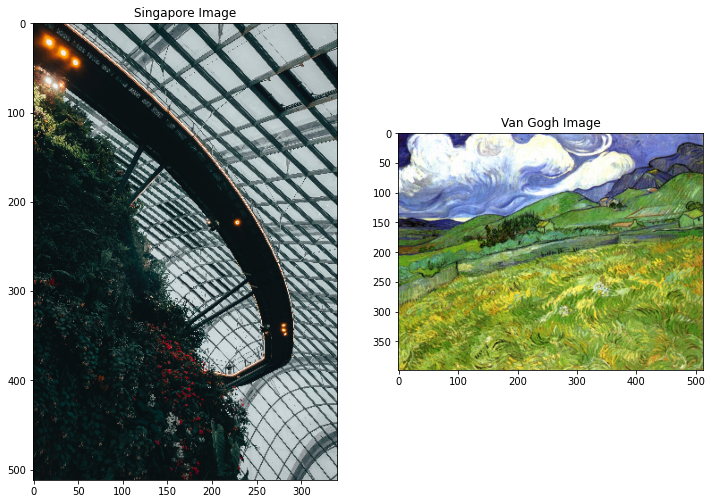

In [6]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Singapore Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Van Gogh Image')

## Neural Style Transfer

In Neural Style Transfer, we use VGG19 to extract features from style and content images, which we can use to construct a gram matrix and minimise out image's output relative to each target.

First, let's make sure VGG19 is working fine.

In [7]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)

predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

40960/35363 [==================================] - 0s 0us/step


[('greenhouse', 0.76046467),
 ('steel_arch_bridge', 0.1286913),
 ('dome', 0.028194098),
 ('radio_telescope', 0.012925445),
 ('suspension_bridge', 0.0061742933)]

Now, let's build our VGG19 Model, extrating only the layers we wish to use for our Neural Style Transfer

In [8]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [9]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

We can extract the layers we want for our style image and calculate the gram matrix

In [10]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

80142336/80134624 [==============================] - 1s 0us/step
block1_conv1
  shape:  (1, 398, 512, 64)
  min:  0.0
  max:  851.307
  mean:  33.87888

block2_conv1
  shape:  (1, 199, 256, 128)
  min:  0.0
  max:  3127.6401
  mean:  174.11604

block3_conv1
  shape:  (1, 99, 128, 256)
  min:  0.0
  max:  7834.099
  mean:  161.53897

block4_conv1
  shape:  (1, 49, 64, 512)
  min:  0.0
  max:  19910.693
  mean:  639.48096

block5_conv1
  shape:  (1, 24, 32, 512)
  min:  0.0
  max:  3743.2761
  mean:  46.782314



In [11]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [12]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

Use our StyleContentModel to properly extract and handle style and content image

In [13]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.09727405
    max:  31199.777
    mean:  947.52893

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  386667.94
    mean:  34990.473

   block3_conv1
    shape:  (1, 256, 256)
    min:  4.1757727
    max:  1125067.4
    mean:  34597.375

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  13682112.0
    mean:  377451.78

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  295167.25
    mean:  2274.0745

Contents:
   block5_conv2
    shape:  (1, 32, 21, 512)
    min:  0.0
    max:  1422.1936
    mean:  16.871603


Now, to train our Neural Style Transfer Model

In [14]:
# Style and content targets
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

We first need to make our loss function, to minimise the loss between the image's output relative to each target.

In [15]:
image = tf.Variable(content_image)

In [16]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [17]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [18]:
style_weight=1e-2
content_weight=1e4

In [19]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Now that we have the loss function, we can use it in our training tf.function

In [20]:
total_variation_weight=30

In [21]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Train our Neural Style Transfer Model

In [22]:
image = tf.Variable(content_image)

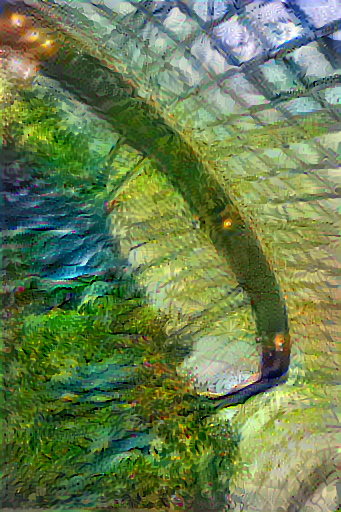

Train step: 1000
Total time: 66.4


In [23]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Cool! It seems to work pretty well, let's compare it with the original image

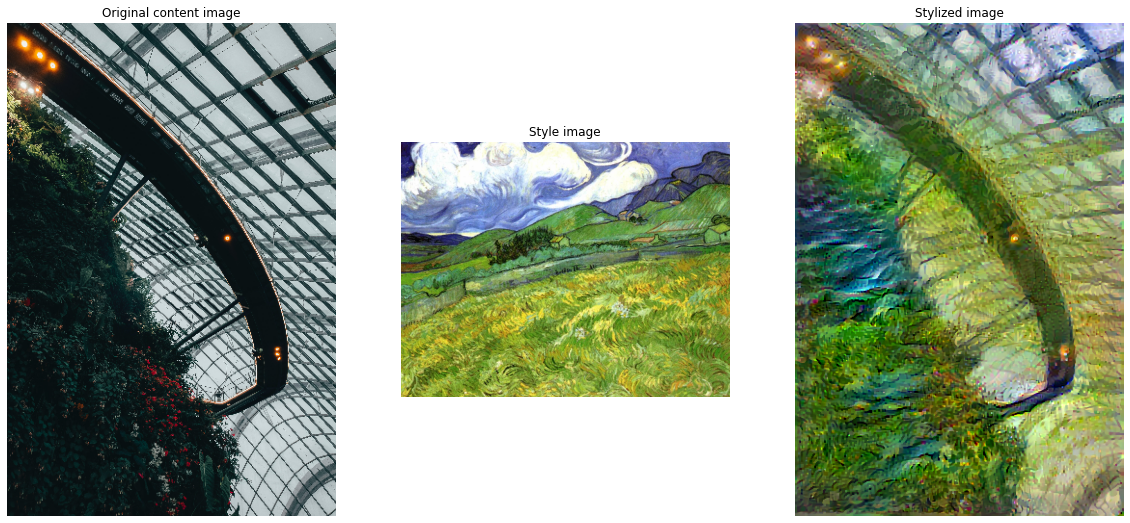

In [31]:
images = [load_img(content_path), load_img(style_path), image]
titles=['Original content image', 'Style image', 'Stylized image']

plt.figure(figsize=(20,15))
for i in range(3):
  plt.subplot(1, 3, i+1)
  plt.imshow(images[i][0], aspect='equal')
  plt.axis('off')
  plt.title(titles[i] if len(titles) > i else '')
plt.show()


It doesn't look bad at all! However, by using Neural Style Transfer, we have to train for every new pair of content and style images, if only there was a way to make a generalised model.....

# Check out **Part 2** for Cycle GAN Implementation

### References

https://www.tensorflow.org/tutorials/generative/style_transfer

https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization

https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398